In [128]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import dexplot as dxp

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

pd.set_option('display.max_rows', 10)

In [129]:
# plot settings

# custom color palette: 
#colors = ['#365b6d', '#41c1ba', '#289dd2', '#6c9286', '#f2f1ec', '#fa9939']
#365b6d - dark blue
#41c1ba - turquoise
#289dd2 - medium blue
#6c9286 - muddy green
#fa9939 - orange 
#f2f1ec - off-white

# Set your custom color palette

#sns.set(style="white", rc={"axes.facecolor": "#f2f1ec", "figure.facecolor": "#f2f1ec"}) 
#custom_palette = sns.set_palette(sns.color_palette(colors))
#sns.set_palette(sns.color_palette(colors))

# for multiple plots
# sns.despine(left=True, bottom=True)

In [130]:
# set seaborn options globally
colors = ['#365b6d', '#41c1ba', '#289dd2', '#6c9286', '#f2f1ec', '#fa9939']
custom_palette = sns.set_palette(sns.color_palette(colors))
custom_params = {"axes.facecolor": "#f2f1ec", 
"figure.facecolor": "#f2f1ec",
'figure.titleweight': 'bold',
'figure.titlesize': 28,#'large',
'grid.alpha': 1.0,
'font.size': 16.0,
'font.weight': 'bold',
'axes.labelsize': 16,
'axes.labelcolor': '#365b6d',
'axes.titlepad': 10.0,
'axes.titlesize': 'large',
'xtick.labelsize': 16,
'xtick.color': '#365b6d',
'xtick.bottom': True,
'ytick.labelsize': 16,
'ytick.color': '#365b6d',
'ytick.left': True,
'text.color' : '#365b6d',
#'legend.labelcolor': '#365b6d',
'legend.title_fontsize': 12.0,
'legend.frameon': False,
'axes.linewidth': 3,#0.8,
'axes.spines.left': True,
'axes.spines.bottom': True,
'axes.spines.right': True,
'axes.spines.top': True,
'axes.edgecolor': '#365b6d',
'axes.labelweight': 'bold',
'axes.titleweight': 'bold',
'patch.edgecolor': '#f2f1ec'
}
sns.set_theme(style="white", palette=colors, rc=custom_params)

# Preliminaries from kappa_combined_clean.ipynb

In [131]:
# import features for tree-based models
X_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test_comb =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

gbc = GradientBoostingClassifier(n_estimators=200,subsample=1, max_leaf_nodes=31, max_features='log2', max_depth=5, loss = 'log_loss', learning_rate=0.025, random_state=42)
gbc.fit(X_train_comb,y_train_comb)
# Performance on test
y_pred = gbc.predict(X_test_comb)
#our_metrics(y_test_comb,y_pred)
# Performance on train
y_pred_tr = gbc.predict(X_train_comb)
#our_metrics(y_train_comb,y_pred_tr)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Preliminaries for Baseline Model

In [132]:
df_processed = pd.read_csv('../data/petfinder-adoption-prediction/train/df_processed.csv')

X_baseline = df_processed[["age_bin", "photoamt_11"]]
y = df_processed["adoptionspeed"]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_baseline, y, random_state=42, stratify=y)
baseline = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 15)
baseline.fit(X_train_bl, y_train_bl)

y_pred_bl = baseline.predict(X_test_bl)
#our_metrics(y_test_bl, y_pred_bl, normalize=True)

In [283]:
df_bl_pred = X_test_bl.copy()
df_bl_pred['adoptionspeed']=y_test_bl
df_bl_pred['adoptionspeed_pred']=y_pred_bl
df_bl_pred

,age_bin,photoamt_11,adoptionspeed,adoptionspeed_pred
3449,0,2.0,1,1
2970,0,4.0,1,1
6594,0,6.0,2,2
2484,1,2.0,4,4
1070,0,1.0,2,2
...,...,...,...,...
3880,2,2.0,4,4
4686,2,3.0,3,4
2655,0,3.0,1,1
9151,0,2.0,4,1


## Preparing Data for Plotting

In [201]:
# confusion matrix of best model
cm = confusion_matrix(y_test_comb, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
total = cm.sum().sum()
cm_norm_all = cm / total

# confusion model of baseline model
cm_bl = confusion_matrix(y_test_bl, y_pred_bl)
cm_bl_norm = cm_bl.astype('float') / cm_bl.sum(axis=1)[:, np.newaxis]
total_bl = cm_bl.sum().sum() # = total
cm_bl_norm_all = cm_bl / total_bl

In [134]:
# get diagonal values
perc = cm_norm.diagonal()
perc_bl = cm_bl_norm.diagonal()

In [135]:
df_bl = pd.DataFrame(columns=[ 'accuracy'], data=np.transpose([ perc_bl]))
df_bl['adoptionspeed']= [1,2,3,4]
df_bl['model'] = 'baseline'
df_bl

,accuracy,adoptionspeed,model
0,0.375180,1,baseline
1,0.228824,2,baseline
2,0.130094,3,baseline
3,0.668831,4,baseline


In [136]:
df_best = pd.DataFrame(columns=[ 'accuracy'], data=np.transpose([ perc]))
df_best['adoptionspeed']= [1,2,3,4]
df_best['model'] = 'best_model'
df_best

,accuracy,adoptionspeed,model
0,0.388167,1,best_model
1,0.391909,2,best_model
2,0.153605,3,best_model
3,0.659740,4,best_model


In [137]:
df = pd.concat([df_bl, df_best])
df

,accuracy,adoptionspeed,model
0,0.375180,1,baseline
1,0.228824,2,baseline
2,0.130094,3,baseline
3,0.668831,4,baseline
0,0.388167,1,best_model
1,0.391909,2,best_model
2,0.153605,3,best_model
3,0.659740,4,best_model


In [138]:
# get accuracy score of best model for reference line
acc = accuracy_score(y_test_comb, y_pred)
acc_bl = accuracy_score(y_test_comb, y_pred_bl)
k = cohen_kappa_score(y_test_comb, y_pred, weights='quadratic')
k_bl = cohen_kappa_score(y_test_comb, y_pred_bl, weights='quadratic')

In [139]:
df_scores = pd.DataFrame(columns=['model','score_name'], data=np.transpose([['Baseline']*2 + ['Best Model']*2, ['accuracy', 'kappa_score']*2 ]))
df_scores['score'] = [acc_bl, k_bl, acc, k]
df_scores

,model,score_name,score
0,Baseline,accuracy,0.359267
1,Baseline,kappa_score,0.221915
2,Best Model,accuracy,0.409751
3,Best Model,kappa_score,0.354709


## Model Comparison Plots

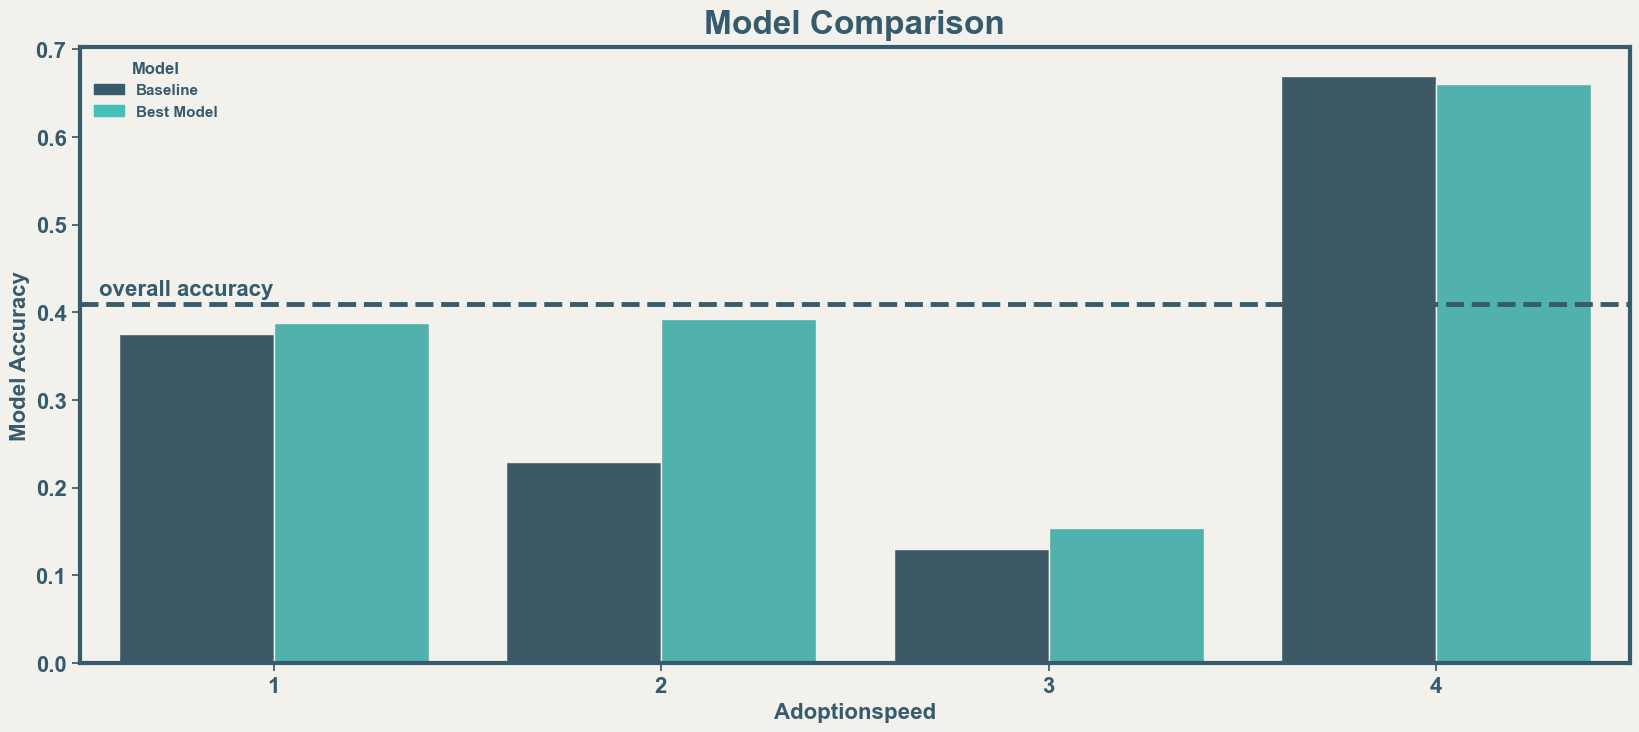

In [140]:
bbox = dict(boxstyle="round", fc='#41c1ba')#fc="0.8") box for annotations
fig = plt.figure(figsize=(20,8))
mod_plot = sns.barplot(
    data=df, 
    x='adoptionspeed', 
    y = 'accuracy',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    # shrink=3
    )
#h,l=mod_plot.get_legend_handles_labels()
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])
legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')


plt.xlabel('Adoptionspeed')
plt.ylabel('Model Accuracy')
plt.title('Model Comparison', fontsize=24)
# plt.xticks(ticks=np.linspace(0,18,10))
# # add vertical line
mod_plot.axhline(y=acc, linewidth=3.5, linestyle='dashed')
# Annotate hline
mod_plot.text(-0.45, acc + 0.01, 'overall accuracy')
# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
plt.show();

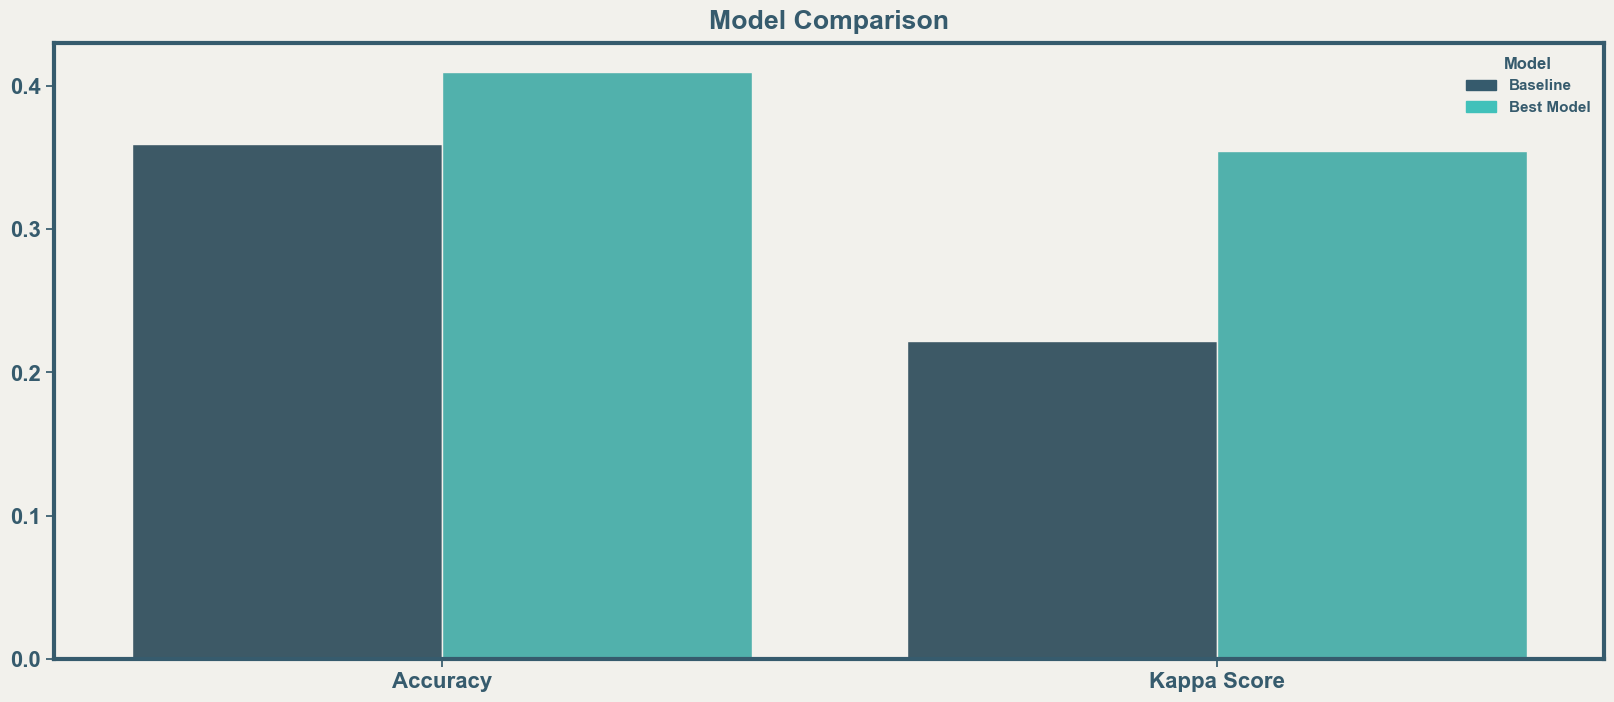

In [141]:
fig = plt.figure(figsize=(20,8))
scores_plot = sns.barplot(
    data=df_scores, 
    x='score_name', 
    y = 'score',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    )

legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')

plt.xlabel('')
plt.ylabel('')
plt.yticks(ticks=np.linspace(0,0.4,5))
scores_plot.set_xticklabels(['Accuracy', 'Kappa Score'])
plt.title('Model Comparison')#, fontsize=24)

# safe figure as...
#plt.savefig('../images/presentation/scores_plot.jpg')
plt.show();

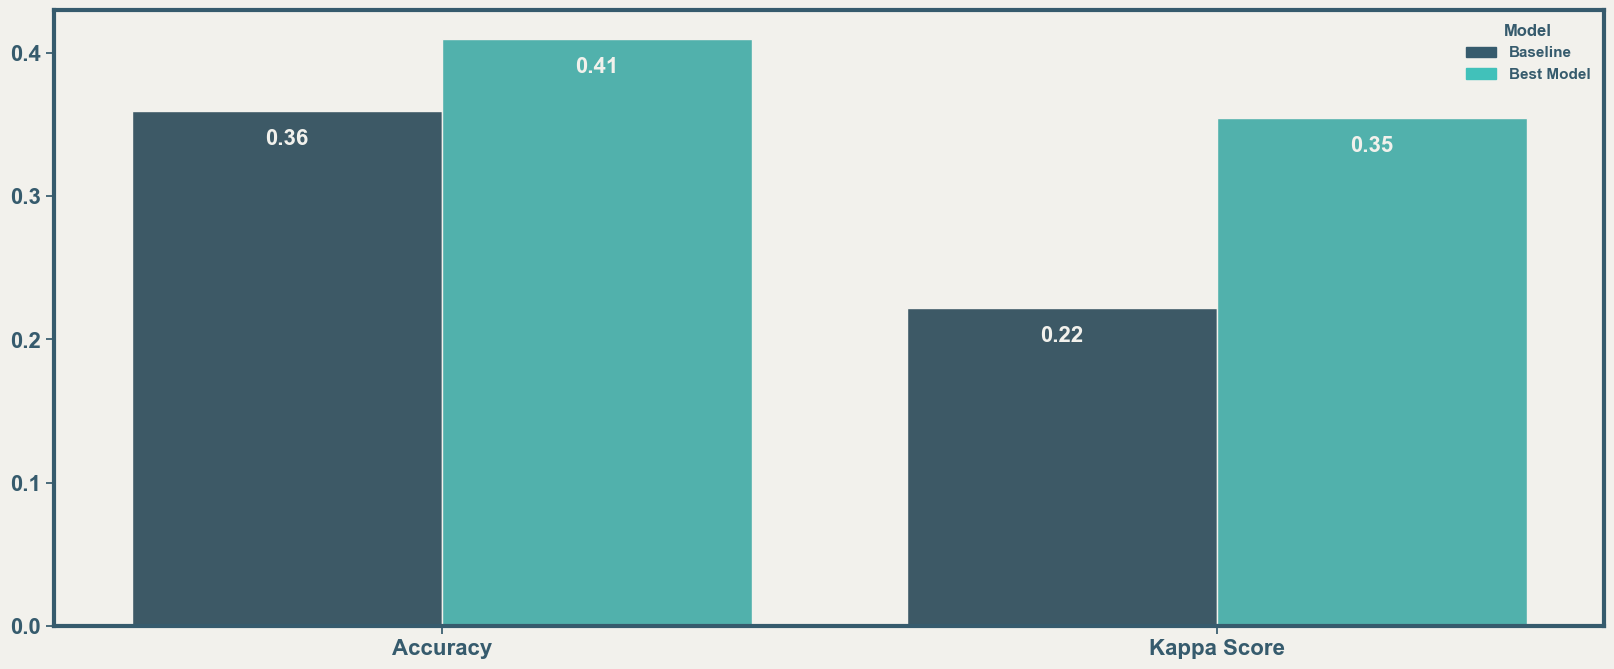

In [142]:
fig = plt.figure(figsize=(20,8))
scores_plot = sns.barplot(
    data=df_scores, 
    x='score_name', 
    y = 'score',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    )

legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')

plt.xlabel('')
plt.ylabel('')
scores_plot.set_xticklabels(['Accuracy', 'Kappa Score'])
#plt.title('Model Comparison')#, fontsize=24)

for g in scores_plot.patches:
    scores_plot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -20),
                   textcoords = 'offset points',
                   color = '#f2f1ec')
plt.yticks(ticks=np.linspace(0,0.4,5))
# safe figure as...
#plt.savefig('../images/presentation/scores_plot.jpg')
plt.show();

## Best Model Plot

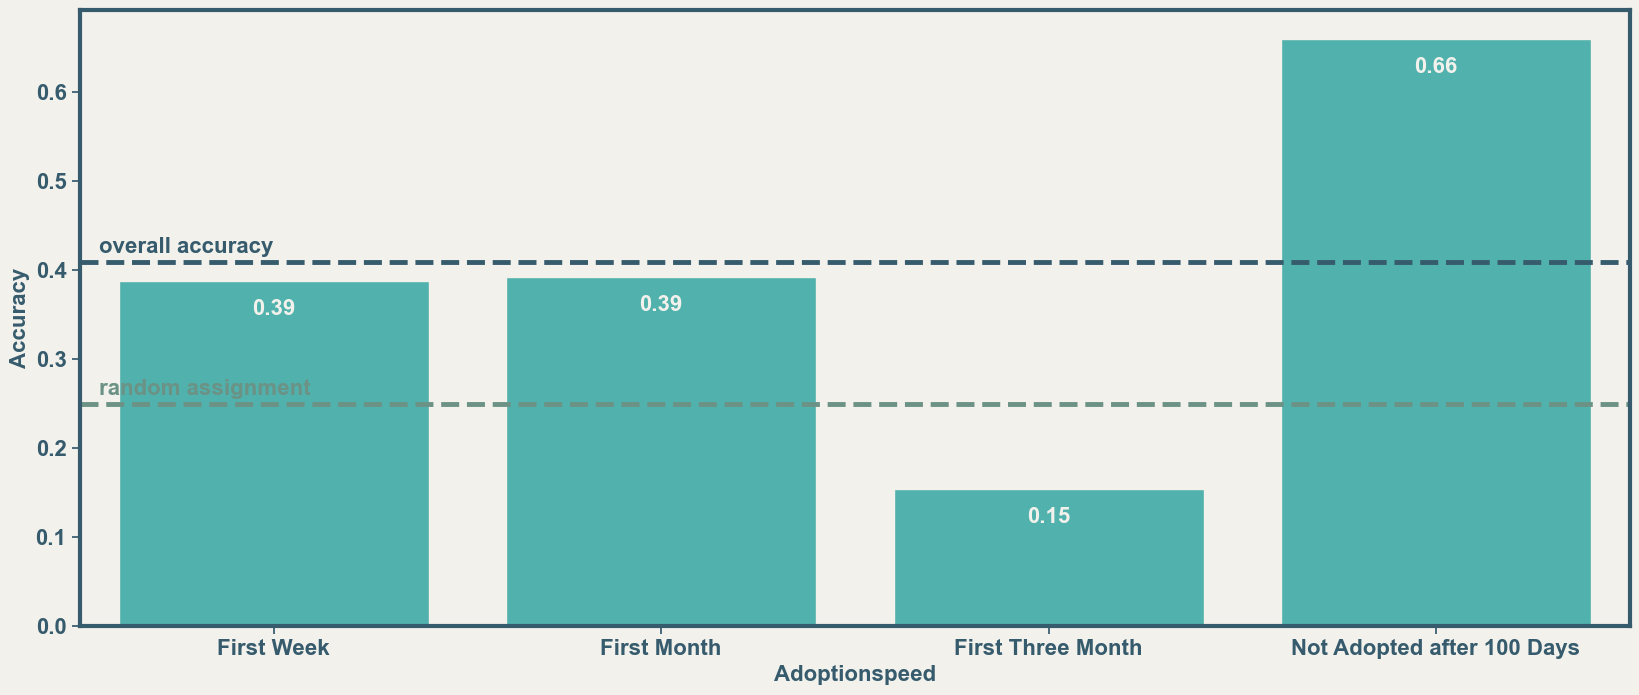

In [143]:
#bbox = dict(boxstyle="round", fc='#41c1ba')#fc="0.8") box for annotations
fig = plt.figure(figsize=(20,8))
mod_plot = sns.barplot(
    data=df.query('model=="best_model"'), 
    x='adoptionspeed', 
    y = 'accuracy',
    #hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    color='#41c1ba'
    )
#h,l=mod_plot.get_legend_handles_labels()
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])

plt.xlabel('Adoptionspeed')
plt.ylabel('Accuracy')
#plt.title('Model Performance on Target Groups')#, fontsize=24)
# plt.xticks(ticks=np.linspace(0,18,10))
# # add horizontal line
mod_plot.axhline(y=acc, linewidth=3.5, linestyle='dashed')
# Annotate hline
mod_plot.text(-0.45, acc + 0.01, 'overall accuracy')

mod_plot.axhline(y=0.25, linewidth=3.5, linestyle='dashed', color='#6c9286')
# Annotate hline
mod_plot.text(-0.45, 0.25 + 0.01, 'random assignment', color='#6c9286')
#365b6d - dark blue
#41c1ba - turquoise
#289dd2 - medium blue
#6c9286 - muddy green
#fa9939 - orange 
#f2f1ec - off-white
for g in mod_plot.patches:
    mod_plot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -20),
                   textcoords = 'offset points',
                   color = '#f2f1ec')

# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)
mod_plot.set_xticklabels(['First Week','First Month','First Three Month','Not Adopted after 100 Days'])

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
plt.show();

In [144]:
cm

array([[269, 240,  37, 147],
       [220, 310,  64, 197],
       [126, 219,  98, 195],
       [ 86, 141,  35, 508]])

In [145]:
# idea: 'plot kappa', observations classified in true and adjoining categories
# add cm entries of adjoining categories to diagonal
cm_kappa = [0]*4
for i in range(4):
    for j in range(max(0,i-1),min(3,i+1)+1):
        cm_kappa[i] += cm[i][j]
cm_kappa

[509, 594, 512, 543]

In [146]:
# idea: 'plot kappa', observations classified in true and adjoining categories
# add cm entries of adjoining categories to diagonal
cm_bl_kappa = [0]*4
for i in range(4):
    for j in range(max(0,i-1),min(3,i+1)+1):
        cm_bl_kappa[i] += cm_bl[i][j]
cm_bl_kappa

[381, 523, 476, 562]

In [147]:
cm_kappa_norm = cm_kappa / cm.sum(axis=1)
cm_kappa_norm

array([0.73448773, 0.75094817, 0.80250784, 0.70519481])

In [148]:
cm_bl_kappa_norm = cm_bl_kappa / cm_bl.sum(axis=1)
cm_bl_kappa_norm

array([0.54978355, 0.66118837, 0.7460815 , 0.72987013])

In [149]:
df_kappa_bl = pd.DataFrame(columns=[ 'correct_plus_adjacent'], data=np.transpose([ cm_bl_kappa_norm]))
df_kappa_bl['adoptionspeed']= [1,2,3,4]
df_kappa_bl['model'] = 'baseline'

df_kappa_best = pd.DataFrame(columns=[ 'correct_plus_adjacent'], data=np.transpose([ cm_kappa_norm]))
df_kappa_best['adoptionspeed']= [1,2,3,4]
df_kappa_best['model'] = 'best_model'

df_kappa = pd.concat([df_kappa_bl, df_kappa_best])
df_kappa

,correct_plus_adjacent,adoptionspeed,model
0,0.549784,1,baseline
1,0.661188,2,baseline
2,0.746082,3,baseline
3,0.729870,4,baseline
0,0.734488,1,best_model
1,0.750948,2,best_model
2,0.802508,3,best_model
3,0.705195,4,best_model


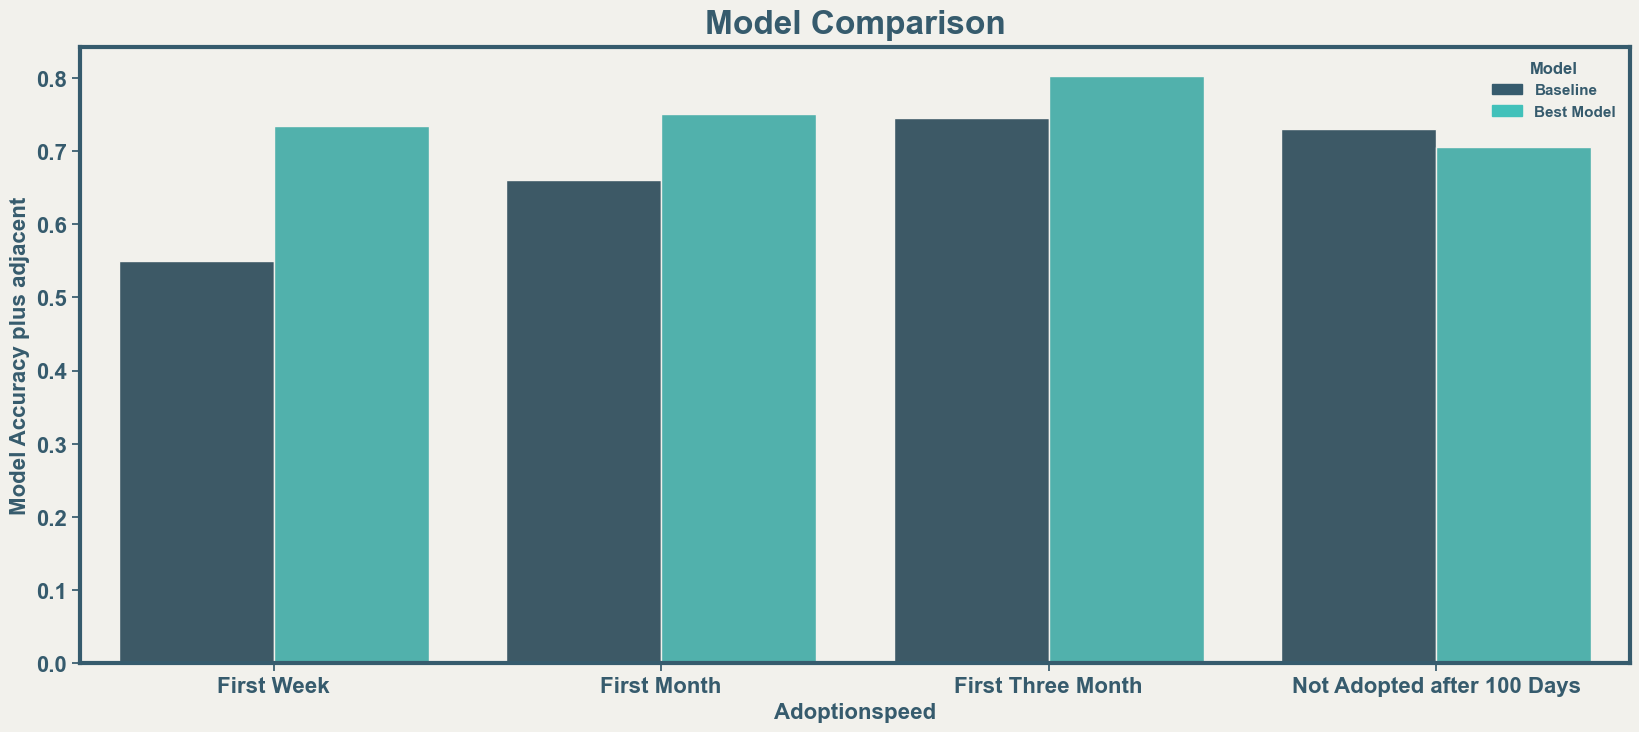

In [150]:
fig = plt.figure(figsize=(20,8))
mod_plot = sns.barplot(
    data=df_kappa, 
    x='adoptionspeed', 
    y = 'correct_plus_adjacent',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    # shrink=3
    )
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])
legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')


plt.xlabel('Adoptionspeed')
plt.ylabel('Model Accuracy plus adjacent')
plt.title('Model Comparison', fontsize=24)
# plt.xticks(ticks=np.linspace(0,18,10))
# # add vertical line
#mod_plot.axhline(y=acc, linewidth=3.5, linestyle='dashed')
# Annotate hline
#mod_plot.text(-0.45, acc + 0.01, 'overall accuracy')
# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
mod_plot.set_xticklabels(['First Week','First Month','First Three Month','Not Adopted after 100 Days'])
plt.show();

In [206]:
perc_bl_correct = cm_bl_norm_all.diagonal().sum()

In [230]:
perc_bl_1off = 0
for i in range(4):
    for j in range(max(0,i-1),min(3,i+1)+1):
        perc_bl_1off += cm_bl_norm_all[i][j]
    perc_bl_1off -= cm_bl_norm_all[i][i]
perc_bl_1off

0.31224066390041494

In [231]:
perc_bl_2off = 0
for i in range(4):
    for j in range(max(0,i-2),min(3,i+2)+1):
        perc_bl_2off += cm_bl_norm_all[i][j]
perc_bl_2off = perc_bl_2off - perc_bl_1off - perc_bl_correct

In [232]:
# perc_bl_2off = [1]*4 - perc_bl - perc_bl_1off
perc_bl_3off = 1 - perc_bl_correct - perc_bl_1off - perc_bl_2off
perc_bl_3off

0.1390041493775932

In [239]:
df_off_bl = pd.DataFrame(columns=['correct', '1off', '2off', '3off'], data=[[perc_bl_correct, perc_bl_1off, perc_bl_2off, perc_bl_3off]])#np.transpose([perc_bl, perc_bl_1off, perc_bl_2off]))
#df_off_bl['adoptionspeed']= [1,2,3,4]
df_off_bl['model'] = 'baseline'
df_off_bl

,correct,1off,2off,3off,model
0,0.359267,0.312241,0.189488,0.139004,baseline


In [240]:
perc_correct = cm_norm_all.diagonal().sum()

perc_1off =  0
for i in range(4):
    for j in range(max(0,i-1),min(3,i+1)+1):
        perc_1off += cm_norm_all[i][j]
    perc_1off -= cm_norm_all[i][i]

perc_2off = 0
for i in range(4):
    for j in range(max(0,i-2),min(3,i+2)+1):
        perc_2off += cm_norm_all[i][j]
perc_2off = perc_2off - perc_1off - perc_correct

perc_3off = 1 - perc_correct - perc_1off - perc_2off

df_off = pd.DataFrame(columns=['correct', '1off', '2off', '3off'], data=[[perc_correct, perc_1off, perc_2off, perc_3off]])
df_off['model'] = 'best model'
df_off

,correct,1off,2off,3off,model
0,0.409751,0.336445,0.173237,0.080567,best model


In [235]:
# bl_1off =  [0]*4
# for i in range(4):
#     for j in range(max(0,i-1),min(3,i+1)+1):
#         bl_1off[i] += cm_bl[i][j]
#     bl_1off[i] -= cm_bl[i][i]

# bl_2off = [1]*4 - cm_bl.diagonal() - bl_1off

# total_correct = cm.diagonal().sum()
# total_1off = _1off.sum()
# total_2off = _2off.sum()
# total_correct_bl = cm_bl.diagonal().sum()
# total_1off_bl = _1off_bl.sum()
# total_2off_bl = _2off_bl.sum()
# # df_off_bl = pd.DataFrame(columns=['correct', '1off', '2off'], data=np.transpose([cm_bl.diagonal(), bl_1off, bl_2off]))
# # df_off_bl['adoptionspeed']= [1,2,3,4]
# # df_off_bl['model'] = 'baseline'

# _1off =  [0]*4
# for i in range(4):
#     for j in range(max(0,i-1),min(3,i+1)+1):
#         _1off[i] += cm[i][j]
#     _1off[i] -= cm[i][i]
# _1off
# _2off = [1]*4 - cm.diagonal() - _1off

# # df_off = pd.DataFrame(columns=['correct', '1off', '2off'], data=np.transpose([cm.diagonal() , _1off, _2off]))
# # df_off['adoptionspeed']= [1,2,3,4]
# # df_off['model'] = 'best model'
# # df_off

In [241]:
df_kappa_all = pd.concat([df_off_bl, df_off])
df_kappa_all

,correct,1off,2off,3off,model
0,0.359267,0.312241,0.189488,0.139004,baseline
0,0.409751,0.336445,0.173237,0.080567,best model


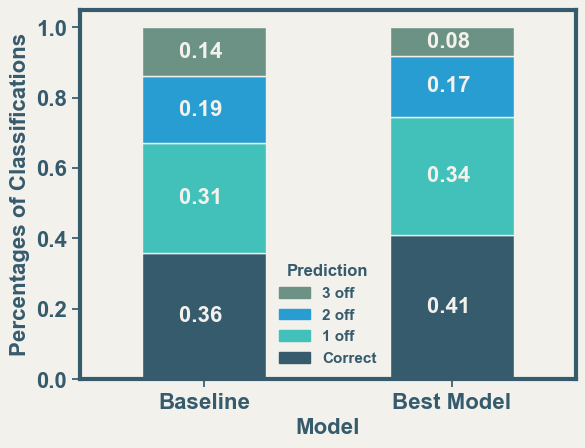

In [254]:
#kappa_plot = sns.barplot(data=df_kappa_all, x='model')#, hue=columns)
kappa_plot = df_kappa_all.plot(kind='bar', stacked=True)#, color=['red', 'pink'])
# Add Title and Labels
#plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Percentages of Classifications')
kappa_plot.set_xticklabels(['Baseline','Best Model'])
plt.xticks(rotation=0)

for g in kappa_plot.patches:
     width, height = g.get_width(), g.get_height()
     x, y = g.get_xy() 
     kappa_plot.text(x+width/2, 
             y+height/2, 
             '{:.2f} '.format(height), 
             horizontalalignment='center', 
             verticalalignment='center',
             color = '#f2f1ec')
#     kappa_plot.annotate(format(g.get_height(), '.2f'),
#                    (g.get_x() + g.get_width() / 2., g.get_height()),
#                    ha = 'center', va = 'center',
#                    xytext = (0, -20),
#                    textcoords = 'offset points',
#                    color = '#f2f1ec')
legend_labels = ['Correct','1 off', '2 off', '3 off', '4 off']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], legend_labels)]
plt.legend(handles=legend_handles[::-1], title='Prediction')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')
plt.show();

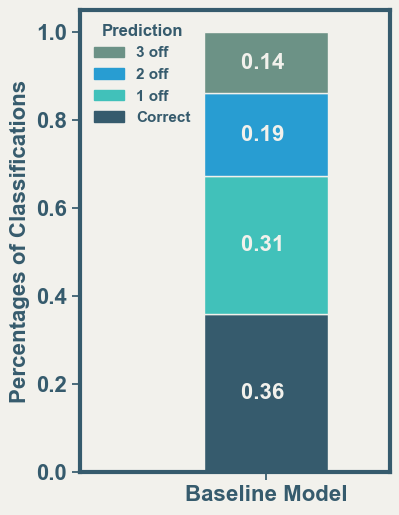

In [282]:
#fig = plt.figure(figsize=(4,8))
kappa_plot_bl = df_kappa_all.query('model == "baseline"').plot(kind='bar', 
                                                               stacked=True, 
                                                               figsize=(4,6), 
                                                               width=0.3
                                                               )#, color=['red', 'pink'])
# Add Title and Labels
#plt.title('Model Comparison')
#plt.xlabel('Model')
plt.ylabel('Percentages of Classifications')
kappa_plot_bl.set_xticklabels(['Baseline Model'])
plt.xticks(rotation=0)

for g in kappa_plot_bl.patches:
     width, height = g.get_width(), g.get_height()
     x, y = g.get_xy() 
     kappa_plot_bl.text(x+width/2, 
             y+height/2, 
             '{:.2f} '.format(height), 
             horizontalalignment='center', 
             verticalalignment='center',
             color = '#f2f1ec')
#     kappa_plot_bl.annotate(format(g.get_height(), '.2f'),
#                    (g.get_x() + g.get_width() / 2., g.get_height()),
#                    ha = 'center', va = 'center',
#                    xytext = (0, -20),
#                    textcoords = 'offset points',
#                    color = '#f2f1ec')
legend_labels = ['Correct','1 off', '2 off', '3 off', '4 off']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], legend_labels)]
plt.legend(handles=legend_handles[::-1], title='Prediction')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')
kappa_plot_bl.set_xlim(-1.5* width, width)
plt.show();

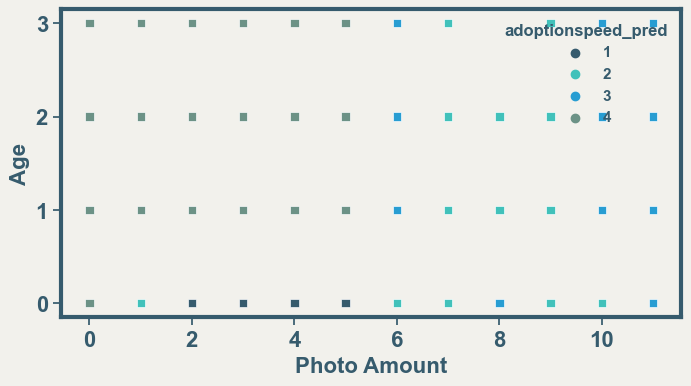

In [298]:
fig = plt.figure(figsize=(8,4))
plot_bs = sns.scatterplot(data=df_bl_pred, x='photoamt_11', y='age_bin', hue='adoptionspeed_pred', palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], marker='s')
# mod_plot = sns.barplot(
#     data=df.query('model=="best_model"'), 
#     x='adoptionspeed', 
#     y = 'accuracy',
#     #hue='model', 
#     # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
#     # multiple='dodge', 
#     # alpha=1,
#     color='#41c1ba'
#     )
#h,l=mod_plot.get_legend_handles_labels()
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])

plt.xlabel('Photo Amount')
plt.ylabel('Age')
#plt.title('Model Performance on Target Groups')#, fontsize=24)
plt.yticks(ticks=np.linspace(0,3,4))

#365b6d - dark blue
#41c1ba - turquoise
#289dd2 - medium blue
#6c9286 - muddy green
#fa9939 - orange 
#f2f1ec - off-white
# for g in mod_plot.patches:
#     mod_plot.annotate(format(g.get_height(), '.2f'),
#                    (g.get_x() + g.get_width() / 2., g.get_height()),
#                    ha = 'center', va = 'center',
#                    xytext = (0, -20),
#                    textcoords = 'offset points',
#                    color = '#f2f1ec')

# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)
#mod_plot.set_xticklabels(['First Week','First Month','First Three Month','Not Adopted after 100 Days'])

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
plt.show();